In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
r_cols = ['userId' ,'movieId' ,'rating' ,'timestamp']

df = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

In [12]:
print(df.head())

       userId  movieId  rating  timestamp  user  movie
75721     877      381     4.0  882677345   873    377
80184     815      602     3.0  878694269   808    601
19864      94      431     4.0  891721716    90    354
76699     416      875     2.0  876696938   409    570
92991     500      182     2.0  883873556   496    356


In [5]:
"""
First, need to perform some preprocessing to encode users and movies as integer indices.
"""
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1682, Min rating: 1.0, Max rating: 5.0


In [6]:
"""
## Prepare training and validation data
"""
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [7]:
"""
## Create the model
We embed both users and movies in to 50-dimensional vectors.
The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).
"""

EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [8]:
"""
## Train the model based on the data split
"""
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 2s 2ms/step - loss: 0.6520 - val_loss: 0.6371
Epoch 2/5
1407/1407 [==============================] - 2s 1ms/step - loss: 0.6270 - val_loss: 0.6282
Epoch 3/5
1407/1407 [==============================] - 2s 1ms/step - loss: 0.6193 - val_loss: 0.6207
Epoch 4/5
1407/1407 [==============================] - 2s 1ms/step - loss: 0.6168 - val_loss: 0.6192
Epoch 5/5
1407/1407 [==============================] - 2s 1ms/step - loss: 0.6165 - val_loss: 0.6170


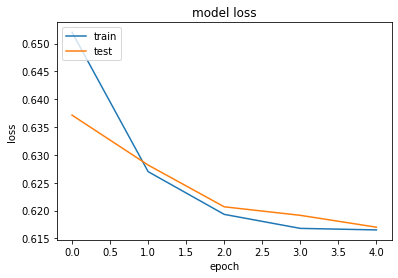

In [9]:
"""
## Plot training and validation loss
"""

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [11]:

m_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url']
movie_df = pd.read_csv('/content/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.release_date)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.release_date)

Showing recommendations for user: 219
Movies with high ratings from user
--------------------------------
Wizard of Oz, The (1939) : 01-Jan-1939
Full Monty, The (1997) : 01-Jan-1997
Heathers (1989) : 01-Jan-1989
Paris, Texas (1984) : 01-Jan-1984
Diva (1981) : 01-Jan-1981
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : 14-Aug-1995
Shawshank Redemption, The (1994) : 01-Jan-1994
Wrong Trousers, The (1993) : 01-Jan-1993
Empire Strikes Back, The (1980) : 01-Jan-1980
Raiders of the Lost Ark (1981) : 01-Jan-1981
12 Angry Men (1957) : 01-Jan-1957
Amadeus (1984) : 01-Jan-1984
Schindler's List (1993) : 01-Jan-1993
Casablanca (1942) : 01-Jan-1942
Rear Window (1954) : 01-Jan-1954
